In [1]:
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import matplotlib.pyplot as plt
import anndata as ad
import numpy as np
import warnings
from scipy.stats import pearsonr
import seaborn as sns
from scipy.cluster.hierarchy import fcluster, linkage
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')


In [2]:
adj = np.load('/mnt/Data18Td/Data/haichao/mouse_connect_data/NT/zxw/mouse_3/zxw_not_symmetric_adj.npy', mmap_mode='r')
print(adj.shape)

adata = sc.read_h5ad('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_NT_cluster/SpaCon_apply_zxw/data/mouse_3/adata_merge.h5ad')
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
allen_region = pd.read_csv('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_NT_cluster/SpaCon_apply_zxw/data/mouse_3/allen_region.csv')
adata.obs['region'] = allen_region['region'].to_list()
adata.obs['spot_num'] = [i for i in range(adata.n_obs)]
adata

(107909, 107909)


AnnData object with n_obs × n_vars = 107909 × 1122
    obs: 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id', 'region', 'spot_num'
    uns: 'log1p'

### subregion th ctx correlation

In [3]:
th_regions = ['AD', 'AMd', 'AMv', 'AV', 'CL', 'CM', 'IAD', 'IAM', 'IGL', 'IMD', 'LD', 'LGv', 'LH', 'LP', 'MD', 'MGd', 'MGm', 'MGv', 'MH', 'PCN', 'PF', 'PIL', 'PO', 'POL',
                'PP', 'PR', 'PT', 'PVT', 'PoT', 'RE', 'RH', 'RT', 'SGN', 'SMT', 'SPA', 'SPFm', 'SPFp', 'VAL', 'VM', 'VPL', 'VPLpc', 'VPM', 'VPMpc', 'Xi']
ctx_regions = ['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo',
                'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm',
                'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd',
                'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs',
                'TEa', 'VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp',
                'VISpl', 'VISpm', 'VISpor', 'VISrl']

adata_ctx_th_area = adata[(adata.obs['region'].str.startswith(tuple(ctx_regions))) | (adata.obs['region'].isin(th_regions))]
adata_ctx_th_area.obs['CT_spot_num'] = [i for i in range(adata_ctx_th_area.n_obs)]
adata_ctx_th_area.obs['ctx_or_th'] = 'nan'
for c in ctx_regions:
    adata_ctx_th_area.obs.loc[adata_ctx_th_area.obs['region'].str.startswith(c), 'ctx_or_th'] = 'ctx'
for c in th_regions:
    adata_ctx_th_area.obs.loc[adata_ctx_th_area.obs['region']==c, 'ctx_or_th'] = 'th'
adata_ctx_th_area.obs

,x,y,z,section,NT_index,Cells_id,region,spot_num,CT_spot_num,ctx_or_th
2,19.113418,23.994053,46.894548,Zhuang-ABCA-3.005,2,188949490498702611647640449216501815503_304478...,FRP1,0,0,ctx
4,18.921382,24.017347,49.257099,Zhuang-ABCA-3.004,4,123445075025856302518661678660778224944_131347...,FRP1,1,1,ctx
6,19.079053,23.564575,51.258567,Zhuang-ABCA-3.003,6,319072152716142889780926524544977408256_106358...,FRP1,2,2,ctx
7,18.816739,25.041919,43.046671,Zhuang-ABCA-3.007,7,47102176527243727968506801819481818675_1792889...,FRP1,3,3,ctx
9,18.792692,25.077860,45.101231,Zhuang-ABCA-3.006,9,199428730039264634225478952930502449426_202483...,FRP1,4,4,ctx
...,...,...,...,...,...,...,...,...,...,...
148907,94.906133,15.937666,42.404653,Zhuang-ABCA-3.007,148907,106526352840576802488939912804342681931_107003...,RSPd1,75568,33095,ctx
148919,95.201531,17.993761,40.377543,Zhuang-ABCA-3.008,148919,133921573428284040813862276100319739380_145548...,RSPd1,75574,33096,ctx
148971,96.095220,15.844123,42.457680,Zhuang-ABCA-3.007,148971,149021058656557956290496348449572943108_174675...,RSPd1,75604,33097,ctx
148993,97.188915,11.409533,46.662115,Zhuang-ABCA-3.005,148993,107188929587695452503950023602364017291_167314...,RSPd1,75616,33098,ctx


In [4]:
# Generate ROIs

mergecell_num = 20
def cluster_region(df_region, num_points=mergecell_num):
    # Perform hierarchical cluster
    Z = linkage(df_region[['x', 'y', 'z']], method='ward')
    # Divided into clusters according to the results of the cluster, each cluster has about NUM_POINTS individual points
    cluster_labels = fcluster(Z, t=len(df_region) / num_points, criterion='maxclust')
    return cluster_labels

# Initialize a empty cluster label
adata_ctx_th_area.obs['subregion'] = 0

# Perform clusters separately for each area
for region in adata_ctx_th_area.obs['region'].unique():
    mask = adata_ctx_th_area.obs['region'] == region
    if adata_ctx_th_area[adata_ctx_th_area.obs['region'] == region].shape[0] < 15:
        adata_ctx_th_area.obs.loc[mask, 'subregion'] = adata_ctx_th_area.obs.loc[mask, 'region'].apply(lambda x: x + '_1')
        continue
    
    clu_list = cluster_region(adata_ctx_th_area.obs[mask])
    cl_list = [f'{region}_{i}' for i in clu_list]
    adata_ctx_th_area.obs.loc[mask, 'subregion'] = cl_list

adata_ctx_th_area.obs

,x,y,z,section,NT_index,Cells_id,region,spot_num,CT_spot_num,ctx_or_th,subregion
2,19.113418,23.994053,46.894548,Zhuang-ABCA-3.005,2,188949490498702611647640449216501815503_304478...,FRP1,0,0,ctx,FRP1_2
4,18.921382,24.017347,49.257099,Zhuang-ABCA-3.004,4,123445075025856302518661678660778224944_131347...,FRP1,1,1,ctx,FRP1_1
6,19.079053,23.564575,51.258567,Zhuang-ABCA-3.003,6,319072152716142889780926524544977408256_106358...,FRP1,2,2,ctx,FRP1_1
7,18.816739,25.041919,43.046671,Zhuang-ABCA-3.007,7,47102176527243727968506801819481818675_1792889...,FRP1,3,3,ctx,FRP1_2
9,18.792692,25.077860,45.101231,Zhuang-ABCA-3.006,9,199428730039264634225478952930502449426_202483...,FRP1,4,4,ctx,FRP1_2
...,...,...,...,...,...,...,...,...,...,...,...
148907,94.906133,15.937666,42.404653,Zhuang-ABCA-3.007,148907,106526352840576802488939912804342681931_107003...,RSPd1,75568,33095,ctx,RSPd1_3
148919,95.201531,17.993761,40.377543,Zhuang-ABCA-3.008,148919,133921573428284040813862276100319739380_145548...,RSPd1,75574,33096,ctx,RSPd1_3
148971,96.095220,15.844123,42.457680,Zhuang-ABCA-3.007,148971,149021058656557956290496348449572943108_174675...,RSPd1,75604,33097,ctx,RSPd1_3
148993,97.188915,11.409533,46.662115,Zhuang-ABCA-3.005,148993,107188929587695452503950023602364017291_167314...,RSPd1,75616,33098,ctx,RSPd1_2


In [6]:
regions = adata_ctx_th_area.obs['subregion'].values
gene_expression = adata_ctx_th_area.X.A

# Create a DataFrame to integrate regional information and gene expression matrix together
df = pd.DataFrame(gene_expression, columns=adata.var_names)
df['subregion'] = regions

# Calculate the average gene expression by regional grouping and calculate the average gene
region_mean_expression = df.groupby('subregion').mean()
# Convert the result to the matrix format of the regional*gene
region_gene_matrix = region_mean_expression.values
region_gene_matrix.shape

(1719, 1122)

In [7]:
corr_all = np.corrcoef(region_gene_matrix)
corr_all.shape

(1719, 1719)

In [8]:
adata_th = adata_ctx_th_area[adata_ctx_th_area.obs['ctx_or_th'] == 'th']
th_subregions = adata_th.obs['subregion'].unique()
th_subregions.shape

(244,)

In [9]:
adata_ctx = adata_ctx_th_area[adata_ctx_th_area.obs['ctx_or_th'] == 'ctx']
ctx_subregions = adata_ctx.obs['subregion'].unique()
ctx_subregions.shape

(1475,)

In [10]:
region_labels = region_mean_expression.index
ctx_indices = [i for i, label in enumerate(region_labels) if label in ctx_subregions]
th_indices = [i for i, label in enumerate(region_labels) if label in th_subregions]
corr = corr_all[np.ix_(ctx_indices, th_indices)]
corr.shape

(1475, 244)

In [11]:
ctx_regions_df = [region_labels[i] for i in ctx_indices]
th_regions_df = [region_labels[i] for i in th_indices]
corr_df = pd.DataFrame(corr, index=ctx_regions_df, columns=th_regions_df)
corr_df

,AD_1,AMd_1,AMd_2,AMv_1,AV_1,AV_2,AV_3,AV_4,AV_5,CL_1,...,VPM_23,VPM_3,VPM_4,VPM_5,VPM_6,VPM_7,VPM_8,VPM_9,VPMpc_1,VPMpc_2
ACAd1_1,0.596044,0.629380,0.629344,0.640548,0.625990,0.616779,0.625027,0.579291,0.607824,0.661248,...,0.546631,0.580518,0.560330,0.552390,0.588024,0.567292,0.550110,0.595391,0.673908,0.651029
ACAd2/3_1,0.597459,0.627501,0.638063,0.645888,0.624184,0.613061,0.610360,0.584868,0.599027,0.632073,...,0.563330,0.591786,0.587295,0.583098,0.590525,0.565894,0.574953,0.613022,0.647487,0.650415
ACAd2/3_2,0.571027,0.595831,0.606491,0.613162,0.593237,0.584572,0.577454,0.553500,0.566546,0.593970,...,0.539473,0.565224,0.567445,0.557278,0.561655,0.535150,0.554062,0.588653,0.610546,0.617166
ACAd2/3_3,0.553607,0.575565,0.594226,0.598235,0.573342,0.568132,0.569627,0.543022,0.554639,0.581051,...,0.514714,0.539524,0.537075,0.534365,0.534878,0.514530,0.527182,0.561045,0.591705,0.611740
ACAd5_1,0.630058,0.641793,0.647781,0.654390,0.634837,0.628741,0.631047,0.606152,0.623477,0.657897,...,0.572636,0.597883,0.591053,0.575654,0.597200,0.584400,0.576911,0.614796,0.669636,0.661564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VISrl4_1,0.608806,0.629851,0.637136,0.650792,0.617430,0.627219,0.614035,0.611263,0.604888,0.627469,...,0.577205,0.623548,0.610158,0.606235,0.613583,0.559556,0.614110,0.639994,0.649961,0.646791
VISrl5_1,0.649082,0.647604,0.668424,0.675256,0.653244,0.647948,0.637781,0.631115,0.636032,0.648355,...,0.617031,0.645198,0.637634,0.624230,0.644994,0.610415,0.630391,0.650415,0.684320,0.669412
VISrl5_2,0.643372,0.636174,0.654321,0.670814,0.631363,0.641428,0.625480,0.634172,0.618452,0.648326,...,0.587593,0.635670,0.617376,0.604309,0.627833,0.580243,0.623062,0.645508,0.675442,0.656189
VISrl6a_1,0.587644,0.558709,0.591176,0.606841,0.577877,0.581434,0.567537,0.566168,0.559256,0.581017,...,0.536177,0.560639,0.547816,0.527045,0.555997,0.526904,0.540306,0.558628,0.609119,0.590757


#### connection

##### ctx2th conn

In [12]:
ctx_ave_list = []
for c in tqdm(ctx_regions_df):
    adata_ctx_area = adata_ctx_th_area[adata_ctx_th_area.obs['subregion'] == c]

    # break
    idx = adata_ctx_area.obs['spot_num'].tolist()
    temp = np.mean(adj[idx], axis=0)
    ctx_ave_list.append(temp)
    # break
ctx2th_ave = np.vstack(ctx_ave_list)
ctx2th_ave.shape

100%|██████████| 1475/1475 [09:42<00:00,  2.53it/s]


(1475, 107909)

In [13]:
th_ave_list = []
for th_region in tqdm(th_regions_df):
    adata_th_area = adata_ctx_th_area[adata_ctx_th_area.obs['subregion'] == th_region]
    # break
    idx = adata_th_area.obs['spot_num'].tolist()
    # break
    temp = np.mean(ctx2th_ave[:, idx], axis=1)
    th_ave_list.append(temp)

ctx2th_ave = np.column_stack(th_ave_list)
conn_df = pd.DataFrame(data=ctx2th_ave, index=ctx_regions_df, columns=th_regions_df, dtype=float)
ctx2th_ave.shape

100%|██████████| 244/244 [00:00<00:00, 359.77it/s]


(1475, 244)

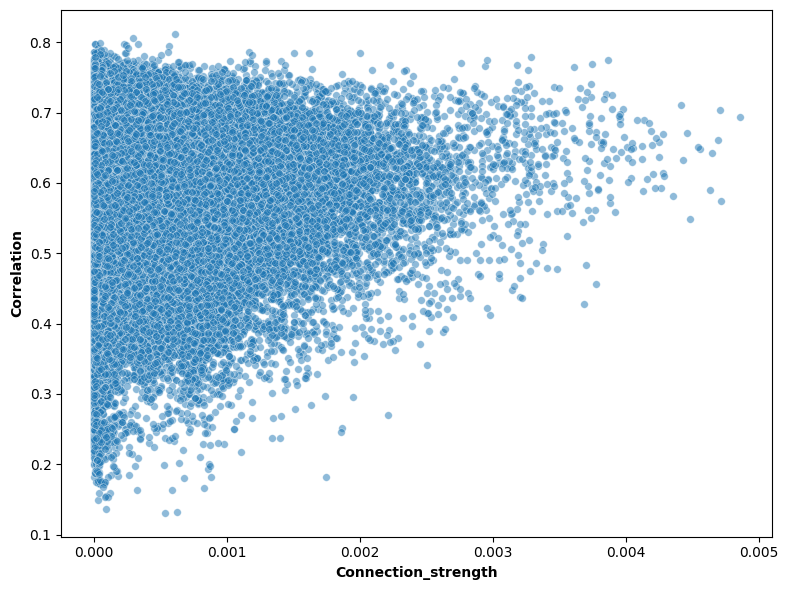

In [14]:
corr = corr.flatten()
conn = ctx2th_ave.flatten()
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(conn, corr, s=30, alpha=0.5)

plt.xlabel('Connection_strength', fontweight='bold')
plt.ylabel('Correlation', fontweight='bold')
plt.tight_layout()

斜率 (slope): 15.42913379110221


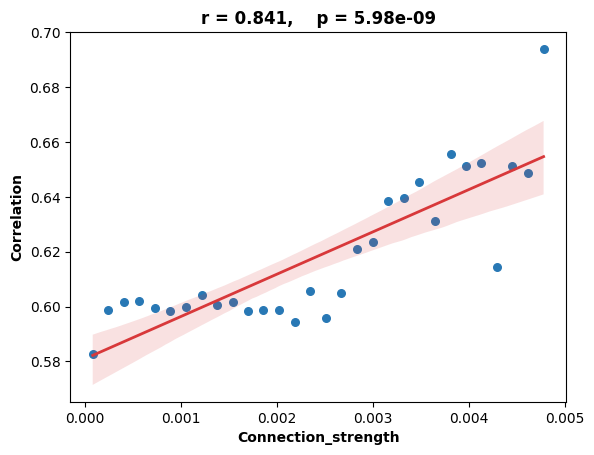

In [28]:
df = pd.DataFrame({'Correlation': corr,
                   'Connection_strength': conn})
# df = df[df['Connection_strength'] > 0.0005]
min_corr = df['Connection_strength'].min()
max_corr = df['Connection_strength'].max()
bins = np.linspace(0, max_corr, 31)
df['group'] = pd.cut(df['Connection_strength'], bins, include_lowest=False)

result = df.groupby('group')['Correlation'].median().reset_index()
result['Connection_strength'] = result['group'].apply(lambda x: (x.left + x.right) / 2)
result = result.dropna(subset=['Correlation'])

import scipy.stats as stats
correlation, p_value = pearsonr(result['Connection_strength'], result['Correlation'])
sns.regplot(data=result, x="Connection_strength", y="Correlation",
            scatter_kws={'s': 30, 'color': '#2878B5', 'alpha': 1, 'marker': 'o'},
            line_kws={'linewidth': 2, 'color': '#D8383A', 'linestyle': '-'})
slope, intercept, r_value, p_value, std_err = stats.linregress(result["Connection_strength"], result["Correlation"])
print(f"(slope): {slope}")
# plt.text(0.95, 0.01, f'Corr: {correlation:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes)
plt.title(f'r = {correlation:.3f},    p = {p_value:.2e}', fontweight='bold')
plt.xlabel('Connection_strength', fontweight='bold')
plt.ylabel('Correlation', fontweight='bold')
plt.savefig('./th_ctx_corr_conn_scatter_line.pdf', format='pdf')
# plt.savefig(f'/mnt/Data16Tc/home/haichao/code/SpaCon/PaperFig/new_brief_comm_fig2/th_ctx_region_correlation/zxw3_all_40bins_merge{mergecell_num}cell.png', dpi=600)

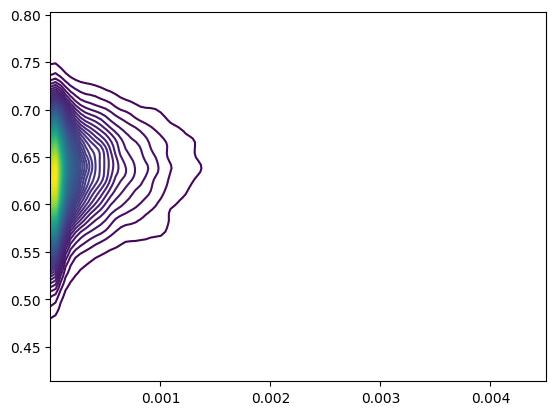

In [33]:
from scipy.stats import gaussian_kde

x = conn
y = corr

# Create a grid
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]

# Calculate nuclear density estimation
positions = np.vstack([xi.ravel(), yi.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values)
z = np.reshape(kernel(positions).T, xi.shape)

# Draw scattered dots and outlines
fig, ax = plt.subplots()
# ax.scatter(x, y, c='k', alpha=0.3)
ax.contour(xi, yi, z, levels=100, cmap='viridis')

plt.show()

Locator attempting to generate 8165 ticks ([0.0, ..., 32656.0]), which exceeds Locator.MAXTICKS (1000).


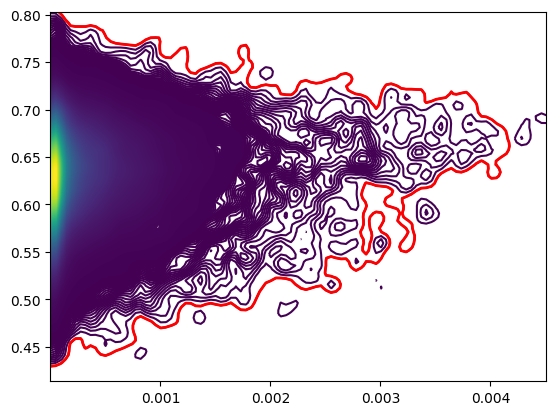

In [34]:
fig, ax = plt.subplots()

contour_set = ax.contour(xi, yi, z, levels=10000, cmap='viridis')

# Get the outermost contour (that is, the first outline)
outermost_contour = contour_set.collections[1]

# Extract the exterior outline path
paths = outermost_contour.get_paths()
outermost_path = paths[0]

# Draw the outermost outline
ax.plot(outermost_path.vertices[:, 0], outermost_path.vertices[:, 1], 'r-', linewidth=2)

plt.show()

# Get the coordinates of the outermost contour
outermost_contour_coords = outermost_path.vertices

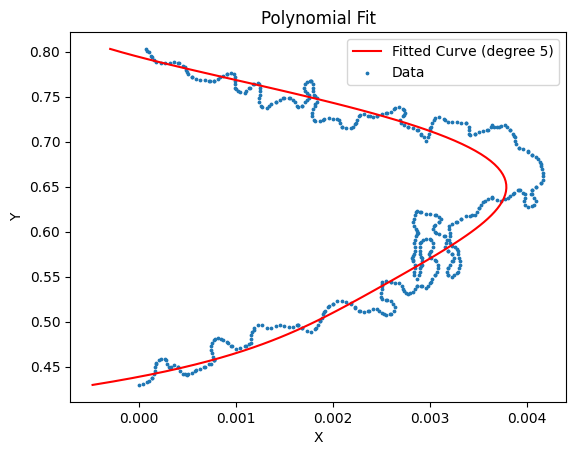

多项式系数（从高阶到低阶）:
x^5: 12.8520
x^4: -39.7188
x^3: 48.3887
x^2: -29.1442
x^1: 8.7148
x^0: -1.0373


In [35]:
x_data = outermost_path.vertices[:, 1]
y_data = outermost_path.vertices[:, 0]

# Select the order of polynomial (you can adjust to get better fitting)
degree = 5

# Use Numpy's polynomial fitting
coeffs = np.polyfit(x_data, y_data, degree)
poly = np.poly1d(coeffs)

# Point to generate the fit curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = poly(x_fit)

# Draw the original data point and fit curve
plt.scatter(y_data, x_data, label='Data', s=3)
plt.plot(y_fit, x_fit, 'r-', label=f'Fitted Curve (degree {degree})')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Polynomial Fit')
plt.show()

# Print polynomial coefficient
print("Polynomial coefficient (from high -level to low -level):")
for i, coeff in enumerate(coeffs):
    print(f"x^{degree-i}: {coeff:.4f}")

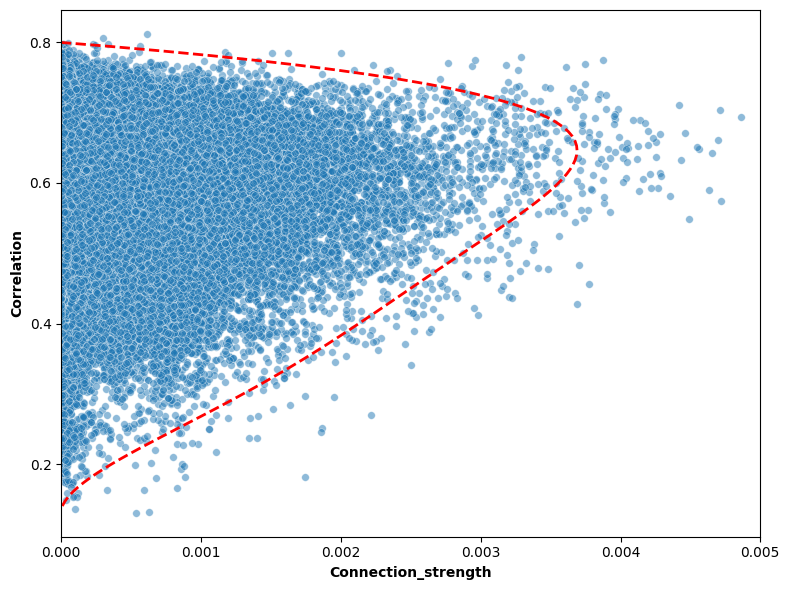

In [97]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(conn, corr, s=30, alpha=0.5)
ax.plot(y_fit, x_fit, 'r--', label=f'Fitted Curve (degree {degree})', linewidth=2)
plt.xlabel('Connection_strength', fontweight='bold')
plt.ylabel('Correlation', fontweight='bold')
plt.xlim(0, 0.005)
ax.set_xticks([0.000, 0.001, 0.002, 0.003, 0.004, 0.005])  # Set the X -axis scale
ax.set_yticks([0.2, 0.4, 0.6, 0.8])  # Set y -axial scale
plt.tight_layout()
# plt.savefig('./corr_conn_scatter.png', dpi=600)

In [ ]:
from scipy.stats import skew, kurtosis, normaltest, jarque_bera
# Polynomial coefficient (from high -level to low -level)
coefficients = coeffs

# Define the polynomial function
poly_func = np.poly1d(coefficients)

# Generate X value
x = np.linspace(min(x_data), max(x_data), 1000)
# Calculate the Y value of polynomial
data = poly_func(x)

# Calculation bias and peak degree
skewness = skew(data)
kurt = kurtosis(data) + 3  # Scipy's Kurtosis function returns the peak degree (Excess Kurtosis), you need to add 3 to get the peak degree

print(f"skewness: {skewness}")
print(f"kurt: {kurt}")

# D'Agostino's K-squared test
k2_stat, k2_p_value = normaltest(data)
print(f"D'Agostino's K-squared: {k2_stat}")
print(f"p: {k2_p_value}")


# Jarque-Bera test
jb_stat, jb_p_value = jarque_bera(data)
print(f"Jarque-Bera: {jb_stat}")
print(f"p: {jb_p_value}")


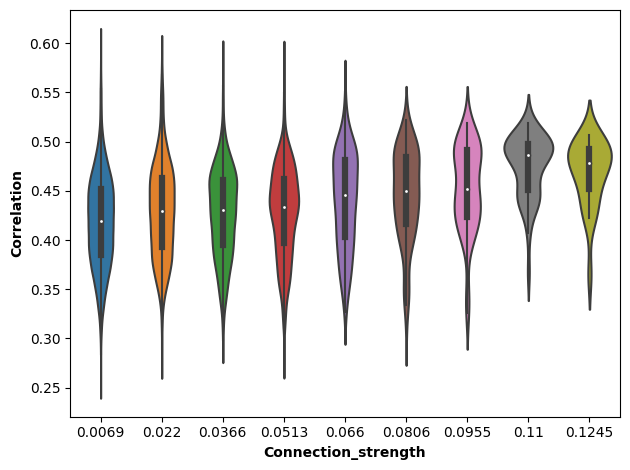

In [17]:
df = pd.DataFrame({'Correlation': corr,
                   'Connection_strength': conn})

min_corr = df['Connection_strength'].min()
max_corr = df['Connection_strength'].max()
bins = np.linspace(min_corr, max_corr, 10)
df['group'] = pd.cut(df['Connection_strength'], bins, include_lowest=True)
df['Connection_strength'] = df['group'].apply(lambda x: round(((x.left + x.right) / 2), 4))
sns.violinplot(x='Connection_strength', y='Correlation', data=df)
plt.xlabel('Connection_strength', fontweight='bold')
plt.ylabel('Correlation', fontweight='bold')
plt.tight_layout()